# Roughness example

Outline
+ Pull in data
    - Get geopandas dataframe with per-photon length along track, elevation, and filtering flags (including YAPC?)
+ Geophysical corrections
+ Remove solar background photons (optional)
    - From latitude, date, and albedo at 532 nm, compute upwelling shortwave within IS-2 band
    - From field of view and energy per photon (h nu), estimate number of photons per unit time
+ Remove specular returns
+ Correct for bias due to reflectance variability (optional)
+ Split into segments by length (or something else?!)
+ Deconvolve (either formally or via forward modeling) transmit pulse
    - Try Nathan's forward modeling approach
    - Direct deconvolution (ifft(fft(photon_distribution)/fft(transmit_pulse_distribution)))
+ Deconvolve subsurface reflections
    - Understand methods from Lu et al...
+ Compare
    - Spatially
    = to gold standard
    - over time?

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sliderule import sliderule, icesat2, earthdata
import geopandas as gpd
from datetime import datetime
from datetime import timedelta
import json
import math

import warnings
from IPython import display
import json
import os

warnings.filterwarnings('ignore')

from scipy.special import erfc
from scipy.stats import exponnorm
from scipy.signal import deconvolve
from sliderule import sliderule, earthdata, h5, icesat2

/srv/conda/envs/notebook/lib/python3.10/site-packages/sliderule/sliderule.py:41: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [3]:
url = "slideruleearth.io"
icesat2.init(url, verbose=False)
asset = "icesat2"

## Pull in data and geophysical corrections

In [4]:
site = 'utqiagvik'

# Load info about data locations
with open(os.path.join('..','..','data','icesat2_tracks.json')) as f:
    dict_info = json.load(f)

# Parse path to get
region = sliderule.toregion(os.path.join('..','..','data','bbox_' + site + '.geojson'))

In [5]:
########## SET PARAMETERS ######################

###### Region of interest #########
site = "utqiagvik" # (blackrock, utqiagvik)
path = f"~/surfit/data/"

##### Read input parameters from .json files #####
poly_fn = f"../../data/bbox_{site}.geojson"

pregion = gpd.read_file(poly_fn)
poly = sliderule.toregion(pregion)["poly"]

# Opening JSON file
f = open("../../data/icesat2_tracks.json")
data = json.load(f)

granule_id = data[site]['granule_id']
track = int(data[site]['beam'][2])
pair = 0 if data[site]['beam'][3]=="l" else 1

time_start = datetime.strptime(granule_id[6:14], "%Y%m%d").strftime("%Y-%m-%d")
time_end = (datetime.strptime(granule_id[6:14], "%Y%m%d") + timedelta(days=1)).strftime("%Y-%m-%d")
rgt = int(granule_id[21:25])
cycle = int(granule_id[25:27])

filename = f"{path}{site}_ATL03_{data[site]['beam']}.csv"
print(filename)
########## SET PARAMETERS ######################

~/surfit/data/utqiagvik_ATL03_gt1l.csv


In [6]:
%%time

##### Set ATL03 sp parameters ##############################
# build sliderule parameters for ATL03 subsetting request
# SRT_LAND = 0
# SRT_OCEAN = 1
# SRT_SEA_ICE = 2
# SRT_LAND_ICE = 3
# SRT_INLAND_WATER = 4
parms = {
    # processing parameters
    "srt": 0,
    "len": 40,
    "res": 40,
    "track": track,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True,
    # all photons
    "cnf": 0,
    "cnt": 5,
    "atl03_geo_fields": ["ref_azimuth", "ref_elev", "geoid"],
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0), 
}

# ICESat-2 data release
release = '006'

# find granule for each region of interest
granules_list = earthdata.cmr(short_name='ATL03', polygon=poly, time_start=time_start, time_end=time_end, version=release)

# create an empty geodataframe
parms["poly"] = poly
# gdf = icesat2.atl03sp(parms, asset=asset, version=release, resources=granules_list)
gdf = icesat2.atl03sp(parms, asset=asset, resources=granules_list)

CPU times: user 1min 24s, sys: 3.3 s, total: 1min 27s
Wall time: 1min 34s


In [7]:
# Reduce dataframe for a single beam
def reduce_dataframe(gdf, RGT=None, GT=None, track=None, pair=None, cycle=None, beam='', crs=4326):
    # convert coordinate reference system
    D3 = gdf.to_crs(crs)
    # reduce to reference ground track
    if RGT is not None:
        D3 = D3[D3["rgt"] == RGT]
    # reduce to ground track (gt[123][lr]), track ([123]), or pair (l=0, r=1) 
    gtlookup = {icesat2.GT1L: 1, icesat2.GT1R: 1, icesat2.GT2L: 2, icesat2.GT2R: 2, icesat2.GT3L: 3, icesat2.GT3R: 3}
    pairlookup = {icesat2.GT1L: 0, icesat2.GT1R: 1, icesat2.GT2L: 0, icesat2.GT2R: 1, icesat2.GT3L: 0, icesat2.GT3R: 1}
    if GT is not None:
        D3 = D3[(D3["track"] == gtlookup[GT]) & (D3["pair"] == pairlookup[GT])]
    if track is not None:
        D3 = D3[D3["track"] == track]
    if pair is not None:
        D3 = D3[D3["pair"] == pair]
    # reduce to weak or strong beams
    # tested on cycle 11, where the strong beam in the pair matches the spacecraft orientation.
    # Need to check on other cycles
    if (beam == 'strong'):
        D3 = D3[D3['sc_orient'] == D3['pair']]
    elif (beam == 'weak'):
        D3 = D3[D3['sc_orient'] != D3['pair']]
    # reduce to cycle
    if cycle is not None:
        D3 = D3[D3["cycle"] == cycle]
    # otherwise, return both beams
    
    D3['x_atc'] = D3['segment_dist']+D3['distance']-np.min(D3['segment_dist'])

    # compute orthometric heights using the onboard geoid model (EGM08)
    D3['height_ortho'] = D3['height'] - D3['geoid']
    
    return D3

In [8]:
beam_type = 'strong'
project_srs = "EPSG:4326" #"EPSG:26912+EPSG:5703"
D3 = reduce_dataframe(gdf, RGT = rgt, track=track, pair = pair, beam=beam_type, crs=project_srs)

In [10]:
D3

,sc_orient,rgt,background_rate,segment_id,segment_dist,track,cycle,solar_elevation,atl08_class,yapc_score,...,landcover,atl03_cnf,ref_azimuth,ref_elev,geoid,pair,geometry,spot,x_atc,height_ortho
time,,,,,,,,,,,,,,,,,,,,,
2022-04-17 01:15:52.821399040,0,381,4.383076e+06,603406,1.208687e+07,1,15,23.647131,4,28,...,255,0,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56400),1,-19.083188,47.466770
2022-04-17 01:15:52.821399040,0,381,4.383076e+06,603406,1.208687e+07,1,15,23.647131,4,19,...,255,1,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-18.968743,5.093244
2022-04-17 01:15:52.821399040,0,381,4.383076e+06,603406,1.208687e+07,1,15,23.647131,1,138,...,255,4,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-18.953404,-0.694184
2022-04-17 01:15:52.821399040,0,381,4.383076e+06,603406,1.208687e+07,1,15,23.647131,4,21,...,255,0,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-18.667858,-106.397987
2022-04-17 01:15:52.821399040,0,381,4.383076e+06,603406,1.208687e+07,1,15,23.647131,4,0,...,255,0,-0.429723,1.567638,-1.200101,0,POINT (-156.48801 71.56399),1,-18.646224,-114.431114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-17 01:15:57.832899072,0,381,5.990883e+06,605182,1.212242e+07,1,15,23.889307,4,0,...,255,0,-0.409115,1.567681,-0.852833,0,POINT (-156.61926 71.24802),1,35542.951260,25.246105
2022-04-17 01:15:57.832899072,0,381,5.990883e+06,605182,1.212242e+07,1,15,23.889307,4,31,...,255,0,-0.409115,1.567681,-0.852833,0,POINT (-156.61926 71.24802),1,35542.827036,71.350876
2022-04-17 01:15:57.832899072,0,381,5.990883e+06,605182,1.212242e+07,1,15,23.889307,4,23,...,255,0,-0.409115,1.567681,-0.852833,0,POINT (-156.61926 71.24803),1,35542.719779,111.000534


In [11]:
D3.columns

Index(['sc_orient', 'rgt', 'background_rate', 'segment_id', 'segment_dist',
       'track', 'cycle', 'solar_elevation', 'atl08_class', 'yapc_score',
       'distance', 'relief', 'snowcover', 'quality_ph', 'height', 'landcover',
       'atl03_cnf', 'ref_azimuth', 'ref_elev', 'geoid', 'pair', 'geometry',
       'spot', 'x_atc', 'height_ortho'],
      dtype='object')

## Forward modeling to infer distributions

In [13]:
# IS-2 pulse modeling functions from Nathan Kurtz
def is2modelfit(xdata,p,range_bins_m_hr):


	'''
	3 input parameters
	p[0] = amplitude scale factor
	p[1] = x_shift to align x-axes of model and obs (surface location)
	p[2] = standard deviation of sfc height (surface roughness)


	xdata = elapsed ns [1.5625, 3.1250, 4.68...]
	'''
	##  add the tau shift to align model and obs
	taufit = (xdata + p[1]).ravel()
	taufit_hr = (range_bins_m_hr + p[1]).ravel()

    #p0 = 1
	c = 299792458; pi = 3.141529654


    ####Generate IS-2 transmit pulse shape
	mu = 0.0
	sigma = 0.116767  #sigma of Gaussian in meters  
	tau = 9.92750  #exponential relaxation time in meters
    ##Convert range bin times to x values in meters with mean of x at tau=0
	mean_xmg = mu + 1/tau
	xmgtau = taufit_hr + mean_xmg
	yy = tau/2*np.exp(tau/2*(2*mu + tau*sigma**2 - 2*xmgtau))*scipy.special.erfc( (mu + tau*sigma**2 - xmgtau) / (np.sqrt(2)*sigma) )

    # Take a running mean of the power and resample to the original resolution
	rb_scale_factor = 5
	avg_factor=np.fix(rb_scale_factor/2 - 0.5)
	yy2 = np.convolve(yy, np.repeat(1.0, avg_factor)/avg_factor, mode='same')
	yy2 = yy2[np.arange(rb_scale_factor-1, np.size(range_bins_m_hr), rb_scale_factor)]
	yy2 = yy2/np.max(yy2)
	yy2[yy2 < 0] = 0
	if np.size(yy2) > np.size(taufit):
		yy2=yy2[0:np.size(yy2)-1]
	yy=yy2

	#yy_rb = wf[1][:]
	#yy = yy/np.max(yy) #normalize to 1
    #####################################



    ##  Log-normal distribution surface pdf with mu = 0
	mu = 0
    ##std_ln = sqrt( (exp(x(3)^2) - 1) * exp(2*mu + x(3)^2));  ##standard deviation of log normal distribution
	sig_surf = p[2]  #surface roughness in meters
	mean_surf = np.exp(mu + sig_surf**2/2)
    ##Convert range bin times to x values in meters with mean of x at tau=0
	xgtau = taufit_hr + mean_surf ##
	#pdb.set_trace()
	surf_pdf = 1/(xgtau*sig_surf*np.sqrt(2*pi)) * np.exp( -1.0*(np.log(xgtau) - mu)**2 / (2*sig_surf**2))  ##log-normal function distribution
	surf_pdf[xgtau < 0] = 0   ##to get rid of negative values which blow up the distribution
	#surf_pdf = surf_pdf/np.max(surf_pdf) #normalize to 1 to make for better numeric calculations
	
	# Take a running mean of the power and resample to the original resolution
	rb_scale_factor = 5
	avg_factor=np.fix(rb_scale_factor/2 - 0.5)
	surf_pdf2 = np.convolve(surf_pdf, np.repeat(1.0, avg_factor)/avg_factor, mode='same')
	surf_pdf2 = surf_pdf2[np.arange(rb_scale_factor-1, np.size(range_bins_m_hr), rb_scale_factor)]
	surf_pdf2 = surf_pdf2/np.max(surf_pdf2)
	surf_pdf2[surf_pdf2 < 0] = 0
	if np.size(surf_pdf2) > np.size(taufit):
		surf_pdf2=surf_pdf2[0:np.size(surf_pdf2)-1]
	surf_pdf=surf_pdf2

	
	

	
    

	
	###Gaussian
    #sig_surf = p[2]
    #sig_surf = 2*sig_surf/c    #converting to time units
    #surf_pdf = 1/(np.sqrt(2*np.pi)*sig_surf) * np.exp(-0.5*(taufit*1e-9/sig_surf)**2)
    #surf_pdf = surf_pdf/max(surf_pdf) #normalize to 1 to make for better numeric calculations


    ##  Convolve surfPDF and YY to get model
	power = np.convolve(surf_pdf,yy)
    ## Change axis size after convolution
	Taxis=np.arange(0,len(power))*(taufit[1]-taufit[0]) + taufit[0]*2

    ##  Get convolved power matrix to same size as input
	startloc = np.argmin(np.abs(Taxis - taufit[0])) # finds location of taufit start on Taxis
	power_final = power[startloc:startloc+len(taufit)]

    ##  normalize, remove negative values
	power_final = power_final/np.max(power_final)
	power_final[power_final < 0] = 0

    ##  Scale amplitude by scale factor
	power_final = p[0] * power_final

	return power_final






def is2modelfit_rough(xdata,p,surf_pdf,range_bins_m_hr):


	'''
	2 input parameters
	p[0] = amplitude scale factor
	p[1] = x_shift to align x-axes of model and obs (surface location)
	
	surf_pdf is normalized surface pdf taken from photon cloud
	'''
	##  add the tau shift to align model and obs
	taufit = (xdata + p[1]).ravel()
	taufit_hr = (range_bins_m_hr + p[1]).ravel()

    #p0 = 1
	c = 299792458; pi = 3.141529654



	   ####Generate IS-2 transmit pulse shape
	mu = 0.0
	sigma = 0.116767  #sigma of Gaussian in meters  
	tau = 9.92750  #exponential relaxation time in meters
    ##Convert range bin times to x values in meters with mean of x at tau=0
	mean_xmg = mu + 1/tau
	xmgtau = taufit_hr + mean_xmg
	yy = tau/2*np.exp(tau/2*(2*mu + tau*sigma**2 - 2*xmgtau))*scipy.special.erfc( (mu + tau*sigma**2 - xmgtau) / (np.sqrt(2)*sigma) )

    # Take a running mean of the power and resample to the original resolution
	rb_scale_factor = 5
	avg_factor=np.fix(rb_scale_factor/2 - 0.5)
	yy2 = np.convolve(yy, np.repeat(1.0, avg_factor)/avg_factor, mode='same')
	yy2 = yy2[np.arange(rb_scale_factor-1, np.size(range_bins_m_hr), rb_scale_factor)]
	yy2 = yy2/np.max(yy2)
	yy2[yy2 < 0] = 0
	if np.size(yy2) > np.size(taufit):
		yy2=yy2[0:np.size(yy2)-1]
	yy=yy2

	#yy_rb = wf[1][:]
	#yy = yy/np.max(yy) #normalize to 1
    #####################################



#    ##  Log-normal distribution surface pdf with mu = 0
#	mu = 0
#    ##std_ln = sqrt( (exp(x(3)^2) - 1) * exp(2*mu + x(3)^2));  ##standard deviation of log normal distribution
#	sig_surf = p[2]  #surface roughness in meters
#	mean_surf = np.exp(mu + sig_surf**2/2)
#    ##Convert range bin times to x values in meters with mean of x at tau=0
#	xgtau = taufit + mean_surf ##
#	surf_pdf = 1/(xgtau*sig_surf*np.sqrt(2*pi)) * np.exp( -1.0*(np.log(xgtau) - mu)**2 / (2*sig_surf**2))  ##log-normal function distribution
#	surf_pdf[xgtau < 0] = 0   ##to get rid of negative values which blow up the distribution
#	#pdb.set_trace()
#	surf_pdf = surf_pdf/np.max(surf_pdf) #normalize to 1 to make for better numeric calculations
#    
    
	
	###Gaussian
    #sig_surf = p[2]
    #sig_surf = 2*sig_surf/c    #converting to time units
    #surf_pdf = 1/(np.sqrt(2*np.pi)*sig_surf) * np.exp(-0.5*(taufit*1e-9/sig_surf)**2)
    #surf_pdf = surf_pdf/max(surf_pdf) #normalize to 1 to make for better numeric calculations


    ##  Convolve surfPDF and YY to get model
	power = np.convolve(surf_pdf,yy)
    ## Change axis size after convolution
	Taxis=np.arange(0,len(power))*(taufit[1]-taufit[0]) + taufit[0]*2

    ##  Get convolved power matrix to same size as input
	startloc = np.argmin(np.abs(Taxis - taufit[0])) # finds location of taufit start on Taxis
	power_final = power[startloc:startloc+len(taufit)]

    ##  normalize, remove negative values
	power_final = power_final/np.max(power_final)
	power_final[power_final < 0] = 0

    ##  Scale amplitude by scale factor
	power_final = p[0] * power_final

	return power_final






def is2modelfit_gaussian(xdata,p,range_bins_m_hr):


	'''
	3 input parameters
	p[0] = amplitude scale factor
	p[1] = x_shift to align x-axes of model and obs (surface location)
	p[2] = standard deviation of sfc height (surface roughness)


	xdata = elapsed ns [1.5625, 3.1250, 4.68...]
	'''
	##  add the tau shift to align model and obs
	taufit = (xdata + p[1]).ravel()
	taufit_hr = (range_bins_m_hr + p[1]).ravel()

    #p0 = 1
	c = 299792458; pi = 3.141529654


    ####Generate IS-2 transmit pulse shape
	mu = 0.0
	sigma = 0.116767  #sigma of Gaussian in meters  
	tau = 9.92750  #exponential relaxation time in meters
    ##Convert range bin times to x values in meters with mean of x at tau=0
	mean_xmg = mu + 1/tau
	xmgtau = taufit_hr + mean_xmg
	yy = tau/2*np.exp(tau/2*(2*mu + tau*sigma**2 - 2*xmgtau))*scipy.special.erfc( (mu + tau*sigma**2 - xmgtau) / (np.sqrt(2)*sigma) )

    # Take a running mean of the power and resample to the original resolution
	rb_scale_factor = 5
	avg_factor=np.fix(rb_scale_factor/2 - 0.5)
	yy2 = np.convolve(yy, np.repeat(1.0, avg_factor)/avg_factor, mode='same')
	yy2 = yy2[np.arange(rb_scale_factor-1, np.size(range_bins_m_hr), rb_scale_factor)]
	yy2 = yy2/np.max(yy2)
	yy2[yy2 < 0] = 0
	if np.size(yy2) > np.size(taufit):
		yy2=yy2[0:np.size(yy2)-1]
	yy=yy2

	#yy_rb = wf[1][:]
	#yy = yy/np.max(yy) #normalize to 1
    #####################################



    ##  Log-normal distribution surface pdf with mu = 0
#	mu = 0
#    ##std_ln = sqrt( (exp(x(3)^2) - 1) * exp(2*mu + x(3)^2));  ##standard deviation of log normal distribution
#	sig_surf = p[2]  #surface roughness in meters
#	mean_surf = np.exp(mu + sig_surf**2/2)
#    ##Convert range bin times to x values in meters with mean of x at tau=0
#	xgtau = taufit + mean_surf ##
#	surf_pdf = 1/(xgtau*sig_surf*np.sqrt(2*pi)) * np.exp( -1.0*(np.log(xgtau) - mu)**2 / (2*sig_surf**2))  ##log-normal function distribution
#	surf_pdf[xgtau < 0] = 0   ##to get rid of negative values which blow up the distribution
#	#pdb.set_trace()
#	surf_pdf = surf_pdf/np.max(surf_pdf) #normalize to 1 to make for better numeric calculations
#    
    
	
	###Gaussian
	sig_surf = p[2]
	surf_pdf = 1/(np.sqrt(2*np.pi)*sig_surf) * np.exp(-0.5*(taufit_hr/sig_surf)**2)
	
		# Take a running mean of the power and resample to the original resolution
	rb_scale_factor = 5
	avg_factor=np.fix(rb_scale_factor/2 - 0.5)
	surf_pdf2 = np.convolve(surf_pdf, np.repeat(1.0, avg_factor)/avg_factor, mode='same')
	surf_pdf2 = surf_pdf2[np.arange(rb_scale_factor-1, np.size(range_bins_m_hr), rb_scale_factor)]
	surf_pdf2 = surf_pdf2/np.max(surf_pdf2)
	surf_pdf2[surf_pdf2 < 0] = 0
	if np.size(surf_pdf2) > np.size(taufit):
		surf_pdf2=surf_pdf2[0:np.size(surf_pdf2)-1]
	surf_pdf=surf_pdf2
	#surf_pdf = surf_pdf/max(surf_pdf) #normalize to 1 to make for better numeric calculations


    ##  Convolve surfPDF and YY to get model
	power = np.convolve(surf_pdf,yy)
    ## Change axis size after convolution
	Taxis=np.arange(0,len(power))*(taufit[1]-taufit[0]) + taufit[0]*2

    ##  Get convolved power matrix to same size as input
	startloc = np.argmin(np.abs(Taxis - taufit[0])) # finds location of taufit start on Taxis
	power_final = power[startloc:startloc+len(taufit)]

    ##  normalize, remove negative values
	power_final = power_final/np.max(power_final)
	power_final[power_final < 0] = 0

    ##  Scale amplitude by scale factor
	power_final = p[0] * power_final

	return power_final



def is2modelfit_pond(xdata,p,range_bins_m_hr):


	'''
	3 input parameters
	p[0] = Pond bottom amplitude scale factor
	p[1] = x_shift to align x-axes of model and obs (surface location)
	p[2] = standard deviation of sfc height (surface roughness)


	xdata = elapsed ns [1.5625, 3.1250, 4.68...]
	'''
	##  add the tau shift to align model and obs
	taufit = (xdata + p[1]).ravel()
	taufit_hr = (range_bins_m_hr + p[1]).ravel()

    #p0 = 1
	c = 299792458; pi = 3.141529654
	alpha = 0.05 #absorption coefficient m^-1 for bubble free ice/water from Perovich, 2003
	vol_backscatter = 0.01  #Volume backscatter 
	


    ####Generate IS-2 transmit pulse shape
	mu = 0.0
	sigma = 0.116767  #sigma of Gaussian in meters  
	tau = 9.92750  #exponential relaxation time in meters
    ##Convert range bin times to x values in meters with mean of x at tau=0
	mean_xmg = mu + 1/tau
	xmgtau = taufit_hr + mean_xmg 
	yy = tau/2*np.exp(tau/2*(2*mu + tau*sigma**2 - 2*xmgtau))*scipy.special.erfc( (mu + tau*sigma**2 - xmgtau) / (np.sqrt(2)*sigma) )

    # Take a running mean of the power and resample to the original resolution
	rb_scale_factor = 5
	avg_factor=np.fix(rb_scale_factor/2 - 0.5)
	yy2 = np.convolve(yy, np.repeat(1.0, avg_factor)/avg_factor, mode='same')
	yy2 = yy2[np.arange(rb_scale_factor-1, np.size(range_bins_m_hr), rb_scale_factor)]
	yy2 = yy2/np.max(yy2)
	yy2[yy2 < 0] = 0
	if np.size(yy2) > np.size(taufit):
		yy2=yy2[0:np.size(yy2)-1]
	yy=yy2

	#yy_rb = wf[1][:]
	#yy = yy/np.max(yy) #normalize to 1
    #####################################



    ##  Log-normal distribution surface pdf with mu = 0
	mu = 0
    ##std_ln = sqrt( (exp(x(3)^2) - 1) * exp(2*mu + x(3)^2));  ##standard deviation of log normal distribution
	sig_surf = p[2]  #surface roughness in meters
	mean_surf = np.exp(mu + sig_surf**2/2)
    ##Convert range bin times to x values in meters with mean of x at tau=0
	xgtau = taufit_hr + mean_surf #+ p[1]##
	surf_pdf = 1/(xgtau*sig_surf*np.sqrt(2*pi)) * np.exp( -1.0*(np.log(xgtau) - mu)**2 / (2*sig_surf**2))  ##log-normal function distribution
	surf_pdf[xgtau < 0] = 0   ##to get rid of negative values which blow up the distribution
	#surf_pdf = surf_pdf/np.max(surf_pdf) #normalize to 1 to make for better numeric calculations
	
	# Take a running mean of the power and resample to the original resolution
	rb_scale_factor = 5
	avg_factor=np.fix(rb_scale_factor/2 - 0.5)
	surf_pdf2 = np.convolve(surf_pdf, np.repeat(1.0, avg_factor)/avg_factor, mode='same')
	surf_pdf2 = surf_pdf2[np.arange(rb_scale_factor-1, np.size(range_bins_m_hr), rb_scale_factor)]
	surf_pdf2 = surf_pdf2/np.max(surf_pdf2)
	surf_pdf2[surf_pdf2 < 0] = 0
	if np.size(surf_pdf2) > np.size(taufit):
		surf_pdf2=surf_pdf2[0:np.size(surf_pdf2)-1]
	surf_pdf=surf_pdf2

	
	

	
    

	
	###Gaussian
    #sig_surf = p[2]
    #sig_surf = 2*sig_surf/c    #converting to time units
    #surf_pdf = 1/(np.sqrt(2*np.pi)*sig_surf) * np.exp(-0.5*(taufit*1e-9/sig_surf)**2)
    #surf_pdf = surf_pdf/max(surf_pdf) #normalize to 1 to make for better numeric calculations


    ##  Convolve surfPDF and YY to get model
	power = np.convolve(surf_pdf,yy)
    ## Change axis size after convolution
	Taxis=np.arange(0,len(power))*(taufit[1]-taufit[0]) + taufit[0]*2

    ##  Get convolved power matrix to same size as input
	startloc = np.argmin(np.abs(Taxis - taufit[0])) # finds location of taufit start on Taxis
	power_final = power[startloc:startloc+len(taufit)]

    ##  normalize, remove negative values
	power_final = power_final/np.max(power_final)
	power_final[power_final < 0] = 0
	
	
	
	## Convolve with volume backscatter profile
	
    # Construct surface and volume scatter profile of water and ice layers as function of time
#taufit_water = (xdata + p0[1] + water_loc_time).ravel()
	taufit_ice = (xdata + p0[1]).ravel()
    
#    # Do this section to make sure one of the points corresponds exactly to an interface point
#    snowtdiff = taufit_snow - snow_loc_time
#    Tdiffs_minloc = np.nanargmin(np.abs(taufit_snow - 1*snow_loc_time))
#    min_Tdiff_snow = np.round(Tdiffs_minloc)
#    snow_offset = snowtdiff[min_Tdiff_snow]
#    
#    icetdiff = taufit_ice
#    Tdiffs_minloc = np.nanargmin(np.abs(taufit_ice))
#    min_Tdiff_ice = np.round(Tdiffs_minloc)
#    ice_offset = snowtdiff[min_Tdiff_ice]
#    
#    pow_pdf_snow_interp_func = interpolate.interp1d(tau_pdf_snow2, pow_pdf_snow, kind='linear', fill_value='extrapolate') # Interpolation function
#    pow_pdf_snow = pow_pdf_snow_interp_func(taufit_snow - snow_offset)
#    
#    pow_pdf_ice_interp_func = interpolate.interp1d(tau_pdf_ice2, pow_pdf_ice, kind='linear', fill_value='extrapolate') # Interpolation function
#    pow_pdf_ice = pow_pdf_ice_interp_func(taufit_ice - ice_offset)
#    
#    taufit_snow = taufit_snow - snow_offset
#    taufit_ice = taufit_ice - ice_offset
#    
#    Tdiffs_minloc = np.nanargmin(np.abs(taufit_snow - 1*snow_loc_time))
#    min_Tdiff_snow = np.round(Tdiffs_minloc)
#
#    Tdiffs_minloc = np.nanargmin(np.abs(taufit_ice))
#    min_Tdiff_ice = np.round(Tdiffs_minloc)
#    
#    # Snow layer backscatter
#    snow_vol_scat = 0 * pow_pdf_snow
#    sig_v_snow = sig_v_uv_snow * k_t_snow**2 / (1 * k_e_snow)
#    alpha_v_snow = k_e_snow
#    
#    snow_vol_scat = (sig_v_snow * alpha_v_snow * np.exp(-1.0 * c_snow * k_e_snow * taufit_snow * 1e-9))
#    novolscat = [idx for idx in range(len(taufit_snow)) if (taufit_snow[idx] <  snow_loc_time)]
#    snow_vol_scat[novolscat] = 0
#    novolscat2 = [idx for idx in range(len(taufit_snow)) if (taufit_snow[idx] >=  snow_loc_time)]
#    snow_vol_scat[novolscat2] = 0
#    snow_vol_scat[min_Tdiff_snow] = snow_backscatter + 0 * sig_v_uv_snow * k_e_snow
#    
#    # Ice layer backscatter
#    
#    sig_v_ice = sig_v_uv_ice * k_t_ice**2 * k_t_snow**2 / (1*k_e_ice)
#    alpha_v_ice = k_e_ice
#    
#    ice_vol_scat = (sig_v_ice * alpha_v_ice * np.exp(-1.0 * k_e_snow * snow_depth/2) * np.exp(-1.0 * alpha_v_ice * c_ice * taufit_ice*1e-9))
#    novolscat = [idx for idx in range(len(taufit_ice)) if (taufit_ice[idx] < 0)]
#    ice_vol_scat[novolscat] = 0
#    # Backscatter at snow surface
#    ice_vol_scat[min_Tdiff_ice] = (ice_backscatter * k_t_snow**2 * np.exp(-1.0 * k_e_snow * snow_depth/2) + (0)/(1) * sig_v_ice * np.exp(-1.0 * k_e_snow * snow_depth/2) * alpha_v_ice * np.exp(-1.0 * alpha_v_ice * c_ice * taufit_ice[min_Tdiff_ice]*1e-9))
#    
#    # Now construct ice waveform and snow waveforms, then sum using superposition
#    tempbad = [idx for idx in range(len(pow_pdf_snow)) if (np.isfinite(pow_pdf_snow)[idx] == False)]
#    pow_pdf_snow[tempbad] = 0
#    tempbad = [idx for idx in range(len(pow_pdf_ice)) if (np.isfinite(pow_pdf_ice)[idx] == False)]
#    pow_pdf_ice[tempbad] = 0
#    
#    power_final_snow = np.convolve(pow_pdf_snow, snow_vol_scat)
#    tau_final_snow = np.arange(0, len(power_final_snow)) * (taufit_snow[1] - taufit_snow[0]) + taufit_snow[0]*2
#    
#    power_final_ice = np.convolve(pow_pdf_ice, ice_vol_scat)
#    tau_final_ice = np.arange(0, len(power_final_ice)) * (taufit_ice[1] - taufit_ice[0]) + taufit_ice[0]*2
#
#    atemp2 = np.nanargmin(np.abs(tau_final_snow - taufit_snow[0]))
#    power_final_snow = power_final_snow[atemp2:atemp2+len(taufit_snow)]
#    tau_final_snow = tau_final_snow[atemp2:atemp2+len(taufit_snow)]
#    
#    atemp2 = np.nanargmin(np.abs(tau_final_ice - taufit_ice[0]))
#    power_final_ice = power_final_ice[atemp2:atemp2+len(taufit_ice)]
#    tau_final_ice = tau_final_ice[atemp2:atemp2+len(taufit_ice)]
#    
#    power_final_snow2_intep_func = interpolate.interp1d(tau_final_snow, power_final_snow, kind='linear', fill_value='extrapolate') # Interpolation function
#    power_final_snow2 = power_final_snow2_intep_func(tau_final_ice)
#    
#    power_final = power_final_snow2 + power_final_ice + mnoise
#    power_final = power_final/np.max(power_final)
#    
#    power_final[np.isnan(power_final)] = 0
#
#    # Take a running mean of the power and resample to the original resolution
#    avg_factor = np.fix(rb_scale_factor/2 - 0.5)
#    #power_final2 = np.convolve(power_final, np.repeat(1.0, avg_factor*2)/avg_factor*2, mode='same')
#    power_final2 = gf.moving_average(power_final, int(avg_factor))
#    
#    power_final2 = power_final2[np.arange(rb_scale_factor-1, 128*rb_scale_factor, rb_scale_factor)]
#
#    ##  normalize, remove negative values
#    power_final2 = power_final2/np.max(power_final2)
#    power_final2[power_final2 < 0] = 0
#power_final = power_final2
	
	
	
	

    ##  Scale amplitude by scale factor
	power_final = p[0] * power_final

	return power_final

In [ ]:
def pulse_dist_fit(df_ph, window_size, fit_opts, surface_fitting_method, 
                   min_photon_confidence_flag, nrb, rb_res):
    """
    Returns surface height distribution that account for transmit pulse shape
    
    Adapted from Nathan Kurtz
    
    Parameters
    ----------
    df_ph : dataframe-like
        DF of photons to fit. Must contain columns 'height_ortho' and 'atl03_cnf'
    window_size : float
        vertical window above and below median to select photons from
    fit_opts : dict
        Options for curve fitting. e.g. `{'ftol': 0.01, 'max_nfev': 500, 'xtol': 0.01}`
    surface_fitting_method : str
        'LogNormal' or 'Normal'
    min_photon_confidence_flag : int
        ATL03 confidence level to use photons
    nrb : int
        Number of range bins for distribution in curve fitting
    rb_res : float
        range bin resolution
        
    Returns
    -------
    (mu, sigma)
        mu and sigma parameters from fit distribution
    
    

In [28]:
####Retrieval length and window size
segment_length = 500.0 #Length of segment in meters to collect photons
window_size = 3.0 #Size in meters to window the photon data around the mean of segment

#Set options for curve fitting and photon selection
fit_opts = {'ftol': 0.01, 'max_nfev': 500, 'xtol': 0.01}
surface_fitting_method = 'LogNormal'
min_photon_confidence_flag = 3

## Deconvolution

In [15]:
hist_res = 0.01 # 1 cm histogram bin resolution

# Transmit pulse parameters
mu = 0.0
sigma = 0.116767  #sigma of Gaussian in meters  
tau = 9.92750  #exponential relaxation time in meters

K = 1/tau # rate parameter in 1/m (how scipy represents the distribution)
##Convert range bin times to x values in meters with mean of x at tau=0

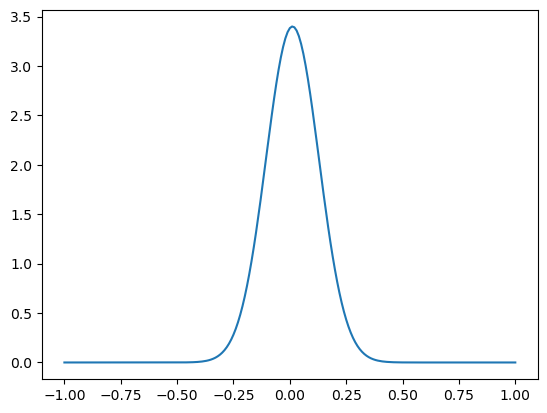

In [16]:
# Test out exp modified gaussian
xx = np.linspace(-1, 1, num=201)
yy = exponnorm.pdf(xx, K, mu, sigma)
plt.plot(xx, yy)

In [18]:
# Get a segment of data
start = 500
segment_length = 100
window_size = 3

ph_ht = D3[(D3.x_atc >= start) & (D3.x_atc < (start + segment_length))].height_ortho.values
ph_ht_crop = ph_ht[np.abs(ph_ht - np.median(ph_ht)) <= window_size]

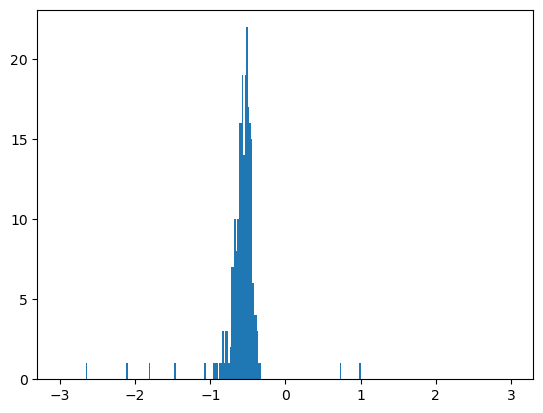

In [19]:
bins = np.linspace(-window_size, window_size, num=int(window_size/hist_res)+1)
emp, _, _ = plt.hist(ph_ht_crop, bins=bins)

In [27]:
# Try deconvolution
pulse = exponnorm.pdf(bins[:-1], K, mu, sigma)

decon = np.fft.ifft(np.fft.fft(emp)/(np.fft.fft(pulse)))

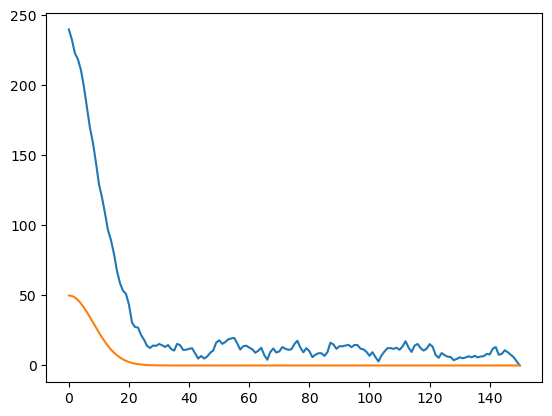

In [26]:
EMP = np.fft.rfft(emp)
PULSE = np.fft.rfft(pulse)

plt.plot(np.abs(EMP))
plt.plot(np.abs(PULSE))

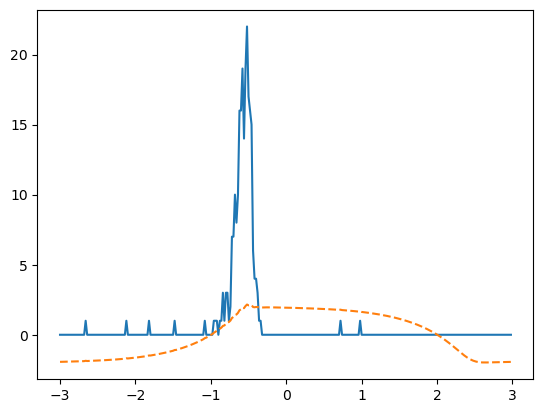

In [28]:
# Plot

plt.plot(bins[:-1], emp)
plt.plot(bins[:-1], decon, '--')

In [24]:
D3.columns

Index(['segment_id', 'background_rate', 'rgt', 'track', 'segment_dist',
       'solar_elevation', 'cycle', 'sc_orient', 'landcover', 'distance',
       'atl08_class', 'atl03_cnf', 'height', 'snowcover', 'relief',
       'quality_ph', 'yapc_score', 'ref_azimuth', 'ref_elev', 'geoid', 'pair',
       'geometry', 'spot', 'x_atc', 'height_ortho'],
      dtype='object')

In [26]:
D3.index.value_counts()

2022-04-17 01:15:56.513099264    46
2022-04-17 01:15:55.173199104    45
2022-04-17 01:15:57.243399168    43
2022-04-17 01:15:57.174599168    43
2022-04-17 01:15:55.713899008    43
                                 ..
2022-04-17 01:15:55.010398976     1
2022-04-17 01:15:52.950598912     1
2022-04-17 01:15:53.653799168     1
2022-04-17 01:15:54.517798912     1
2022-04-17 01:15:53.691698944     1
Name: time, Length: 50033, dtype: int64